* 최초작성일자: 231103
* 실행환경: 구글 코랩

### 구글 드라이브 마운트

In [64]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 구글 드라이브 경로 설정
%cd /content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲


'/content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲'

### 라이브러리 설치, 불러오기

In [65]:
!pip install transformers

In [66]:
!pip install deepface

In [67]:
!pip install faiss-cpu

In [68]:
from transformers import ViTModel

import os
from PIL import Image

from torchvision.transforms import ToTensor

import numpy as np
from tqdm import tqdm

import torch

import faiss

from retinaface import RetinaFace
import matplotlib.pyplot as plt

from deepface import DeepFace
import cv2

### 랜덤씨드 고정

In [69]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 수집한 이미지를 벡터로 만들기
사전훈련된 신경망 vit을 가져와서 인코더 부분을 사용하여 벡터로 만든다
* https://huggingface.co/google/vit-base-patch16-224

In [5]:
model = ViTModel.from_pretrained("google/vit-base-patch16-224")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [7]:
# gpu 사용 가능시에 cuda 선택
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [8]:
model = model.to(device)

In [9]:
# !nvidia-smi

In [10]:
def make_index_lsts():
    input_dir = "주민이미지/"

    file_name_lst = []
    latent_vector_lst = []
    folder_names = os.listdir(input_dir)

    # 텐서로 변환하는 함수
    tf_toTensor = ToTensor()

    model.eval()

    for folder_name in tqdm(folder_names):
        # print(folder_name)

        file_names = os.listdir(input_dir+folder_name)
        for file_name in file_names:
            # print(file_name)
            file_name_lst.append(folder_name+"/"+file_name)
            input = Image.open(input_dir+folder_name+"/"+file_name)
            input = tf_toTensor(input)

            with torch.no_grad():

                latent_vector = model(input.unsqueeze(0).to(device), interpolate_pos_encoding=True)
                latent_vector = latent_vector['pooler_output'][0]

                latent_vector_lst.append(latent_vector)

    return latent_vector_lst, file_name_lst

100%|██████████| 34/34 [02:35<00:00,  4.58s/it]


In [11]:
latent_vector_lst, file_name_lst = make_index_lsts()
latent_vector_lst_numpy = np.array([t.cpu().numpy() for t in latent_vector_lst])

In [12]:
latent_vector_lst_numpy.shape

(380, 768)

In [13]:
np.save('animal_data.npy', latent_vector_lst_numpy)

In [14]:
file_name_lst[:5]

['horse/horse_8.jpg',
 'horse/horse_11.jpg',
 'horse/horse_4.jpg',
 'horse/horse_9.jpg',
 'horse/horse_6.jpg']

In [15]:
# 텍스트 파일로 저장하기
file = open("file_name_lst.txt", "w")
file.write(str(file_name_lst))
file.close()

### Inference

#### 작동 테스트

In [ ]:
# 작동 테스트
# 테스트를 위해 index add했던거로 확인함
# Index는 faiss Index 객체를 의미
# indexes는 우리가 흔히 말하는 정수 인덱스를 의미
k = 3
distances, indexes = Index.search(animal_data[:3], k)

In [ ]:
# animal_data가 전부 Index에 들어가 있어서 각 Top1 인덱스는 자기 자신의 인덱스다.
# 자기 자신과의 거리는 0이므로, 각 Top1 거리 값도 0
distances

array([[  0.     ,  70.91631,  81.45494],
       [  0.     ,  77.96408,  88.66243],
       [  0.     , 124.31059, 129.85442]], dtype=float32)

In [ ]:
# 거리가 가까운 순서대로 index를 출력해줌
# 출력된 인덱스를 다시 사진으로 확인해야 하는 작업이 필요함.
indexes

array([[  0,   4,  11],
       [  1,   3,  10],
       [  2,   1, 189]])

#### 얼굴 클로즈업

In [70]:
# return으로 PIL 타입의 이미지 반환
def crop_face(img_path = "query_images/송가인.png"):

    faces = RetinaFace.extract_faces(img_path = img_path, align = True)

    # face를 찾지 못하면 원본 이미지를 사용한다.
    if len(faces) == 0:
        face = Image.open(img_path)
    else:
        face = faces[0]

    face = Image.fromarray(face)

    return face

In [71]:
# 잘 못찾는 경우도 있음
# 조금 더 가로 여백이 있음

def crop_face_deepface(img_path = "query_images/송가인.png"):

    # 이미지 로드
    image = cv2.imread(img_path)

    # 얼굴 추출
    detected_face = DeepFace.extract_faces(image, enforce_detection = False)

    # 추출된 얼굴 출력
    face = detected_face[0]['face']
    plt.imshow(face)
    plt.show()

    return face

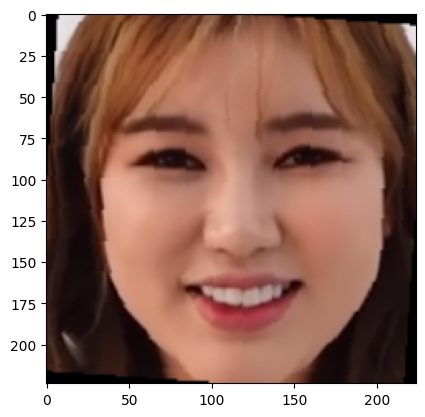

In [72]:
face = crop_face_deepface()

#### 유사도 계산하기
Faiss 알고리즘 사용

In [73]:
# 저장한 임베딩 벡터 불러오기
animal_data = np.load('animal_data.npy', allow_pickle=True)
animal_data.shape

(380, 768)

In [74]:
# 텍스트 파일 읽기
def read_txt_file(filename):
  f = open(filename, 'r')     # mode = 부분은 생략해도 됨
  str = f.read()

  return eval(str)

In [75]:
file_name_lst = read_txt_file('file_name_lst.txt')

In [76]:
# 인덱스 추가하기
Index = faiss.IndexFlatL2(animal_data.shape[1])
print(Index.is_trained)		# True
Index.add(animal_data)
print(Index.ntotal)

True
380


In [77]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲'

In [78]:
model = ViTModel.from_pretrained("google/vit-base-patch16-224")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
# gpu 사용 가능시에 cuda 선택
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = model.to(device)

cpu


In [80]:
model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [81]:
def calculate(face):

    tf_toTensor = ToTensor()

    '''
    input_dir = "query_images/"
    file_name = '송가인.png'
    input = Image.open(input_dir + file_name)
    '''


    model.eval()


    # 이미지 출력
    #img = face
    #base_width= 300
    #wpercent = (base_width / float(img.size[0]))
    #hsize = int((float(img.size[1]) * float(wpercent)))
    #img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)
    #display(img)


    input = tf_toTensor(face)

    with torch.no_grad():
        if input.shape[0] == 4:
            input = input[:3]
        latent_vector = model(input.unsqueeze(0).to(device), interpolate_pos_encoding=True)
        latent_vector = latent_vector['pooler_output'][0]

    return latent_vector

In [90]:
def get_result(latent_vector, k=3):
    distances, indexes = Index.search(latent_vector.cpu().unsqueeze(0), k)

    print('distances:', distances)
    print('indexes[0]:', indexes[0])

    for idx in indexes[0]:
        file_name = file_name_lst[idx]
        print(file_name)

        embedding_img_dir = "주민이미지/"
        input = Image.open(embedding_img_dir + file_name)
        display(input)

In [83]:
img_path = "query_images/송가인.png"

# 얼굴 크롭한 사진을 이용
face = crop_face(img_path)
latent_vector = calculate(face)

distances: [[200.21304 213.98524 219.37732]]
indexes[0]: [214 175  62]
elephant/elephant_6.jpg


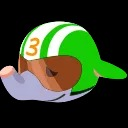

Koala/Koala_7.jpg


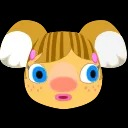

squirrel/squirrel_1.jpg


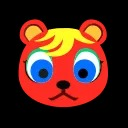

In [91]:
get_result(latent_vector)

#### 누끼제거

In [ ]:
!pip install rembg

In [33]:
from rembg import remove
from PIL import Image

In [34]:
input_dir = "query_images/"

input = Image.open(input_dir+'송가인.png')
output = remove(input)

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 128GB/s]


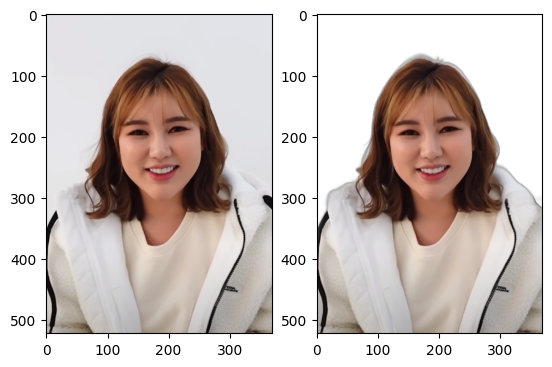

In [35]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(input)

plt.subplot(1,2,2)
plt.imshow(output)

#### 얼굴만 잘라주는 라이브러리 사용 - autocrop (사용X)

In [37]:
!pip install autocrop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.0/159.0 kB 6.2 MB/s eta 0:00:00


In [38]:
from autocrop import Cropper

cropper = Cropper()
cropped_array = cropper.crop(input_dir+'송가인.png')

In [39]:
crop_image = Image.fromarray(cropped_array)

In [40]:
crop_image.size

(500, 500)

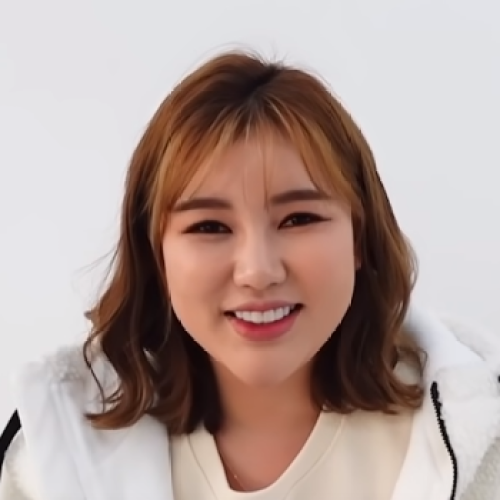

In [41]:
crop_image

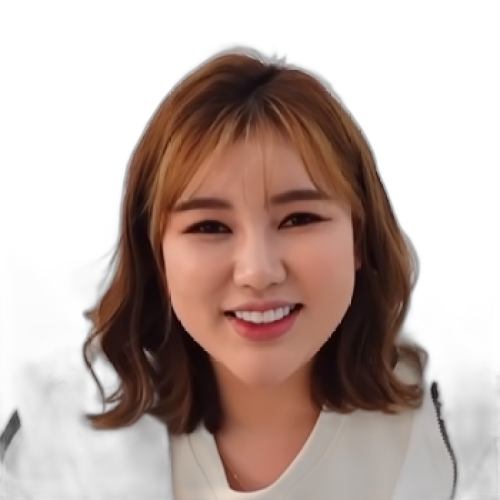

In [42]:
crop_img_output = remove(crop_image)
crop_img_output